# IFSAA

Problem Overview: The goal of this project is to build a client retention model for the IFSSA food hamper distribution program, which aims to predict whether a client will be retained or churned based on a combination of historical interaction data and environmental influences. Retention is classified into two categories: "retained" or "churned," with the target variable being the retention label.

Machine Learning Model Type: This is a classification task. We are interested in predicting the binary outcome ("retained" or "churned") based on historical behavior and external factors. The model will help identify at-risk clients, allowing the program to tailor its outreach strategies and services.

Link to Streamlit app: https://ifssa-client-retention.streamlit.app/

Link to GitHub Repo: https://github.com/ChiomaUU/Client-Prediction

Importing modules and libraries

In [1]:
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot

# Scikit-Learn imports
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, KFold, cross_val_score, cross_validate,
    GridSearchCV, RandomizedSearchCV
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures, FunctionTransformer
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve,
    PrecisionRecallDisplay, classification_report
)

# Machine Learning Models

from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
)

from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import  XGBClassifier



# Model Saving/Loading
import joblib

In [2]:
#!pip install --upgrade numpy
!pip install --upgrade catboost

In [3]:
!pip uninstall -y catboost numpy
!pip install --no-cache-dir numpy catboost


Found existing installation: catboost 1.2.7
Uninstalling catboost-1.2.7:
  Successfully uninstalled catboost-1.2.7
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 72.9 MB/s eta 0:00:00


In [4]:
from catboost import CatBoostClassifier

# Block 1: Feature Review and Enhancement

The feature engineering section was reviewed and we created the following features:


1. **return_binary**: Our target column which will show whether a client will return or not in the next 60 days. This was modified after feedback from demo 1. It returns a ("Yes"/"No") per rolling 60-day period. This helps capture patterns across time even if a client has gaps in visits.
2. **days_since_last_pickup**: Tracks the number of days since the last pickup. Purpose: Indicates client interaction frequency; frequent pickups suggest higher engagement.
3. **days_diff_scheduled_actual**: Measures the difference between scheduled and actual pickup dates. Purpose: Assesses service punctuality; large differences may indicate inefficiency.  
4. **rescheduled_flag**: Binary flag indicating if the pickup was rescheduled (1 = Yes, 0 = No). Purpose: Flags clients with rescheduled pickups; may reflect client behavior or service issues.             
5. **month**: Extracts the month number from the pickup date. Purpose: Captures seasonal trends in demand and client engagement.                
6. **total_visits**: This feature sums the total number of visits (or pickups) made in each neighborhood or location cluster. It helps identify areas with higher service demand.            
7. **avg_days_between_pickups**:  Calculates the average gap between consecutive visits for each client, indicating how often they access the service.    
8. **is_single_pickup**:  This stores the clients who have picked up hampers just once. It helps establish behavioral patterns amongst the clients.                             
9. **latitude**: Coordinates were gotten from the addresses using Google API                    
10.** longitude**: Also extracted using Google API               
11. **distance_to_center**: This measures the distance between the pickup location and the client's address.        
12. **location_cluster**:  allows for spatial analysis, enabling insights into the distribution of demand and client activity across different areas. This can help optimize resource allocation for service delivery.

**Handling Outliers**: The outliers in the the pickup_date and collect_scheduled_date were also eliminated by dropping the months with missing data.

**Feature Correlation and Selection** - This was carried out using Pearson and Chi-square but did not improve the model performance. Using all the features gave a better performing model.


In [5]:
data = pd.read_csv('df.csv')

In [6]:
# Make a copy of the dataset
df = data.copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6909 entries, 0 to 6908
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   agent_related               6909 non-null   object 
 1   new_client_id               6909 non-null   object 
 2   collect_scheduled_date      6909 non-null   object 
 3   collect_token               6909 non-null   object 
 4   datetime_from               6909 non-null   object 
 5   datetime_to                 6909 non-null   object 
 6   hamper_type                 6909 non-null   object 
 7   pickup_date                 6909 non-null   object 
 8   related_scheduler           6909 non-null   object 
 9   unique_client               6909 non-null   object 
 10  Creation Date               6909 non-null   object 
 11  Modified Date               6909 non-null   object 
 12  Creator                     6909 non-null   object 
 13  unique id                   6909 

Dropping more datetime_to, datetime_from, longitude, lattitude, rescheduled_flag and address as we already created new features such as distance_to_center and location_clusters

In [8]:
# Drop datetime_to, datetime_from and address,longitude, latitude and rescheduled_flag columns
df = df.drop(columns=['datetime_to', 'datetime_from', 'address', 'longitude', 'latitude', 'rescheduled_flag', 'new_client_id', 'days_diff_scheduled_actual'])

## Handling Outliers in Pickup and Scheduled Dates

We observed that outliers exist in the pickup dates and  collect scheduled date between 2023-07 to 2023-09 and 2024-10 to 2025-09. These periods were dropped from the dataframe.

In [9]:
import pandas as pd

# Converting pickup date to datetime format
df['pickup_date'] = pd.to_datetime(df['pickup_date'])

# Get the earliest (start) date
start_date = df['pickup_date'].min()

# Get the latest (end) date
end_date = df['pickup_date'].max()

print("Start Date:", start_date)
print("End Date:", end_date)

Start Date: 2023-11-01 13:37:00
End Date: 2024-08-26 15:13:00


In [10]:
import pandas as pd
# Converting 'collect_scheduled_date' to datetime format
df['collect_scheduled_date'] = pd.to_datetime(df['collect_scheduled_date'])

# Get the earliest (start) date
start_date = df['collect_scheduled_date'].min()

# Get the latest (end) date
end_date = df['collect_scheduled_date'].max()

print("Start Date:", start_date)
print("End Date:", end_date)

Start Date: 2023-10-30 03:00:00
End Date: 2025-06-13 03:00:00


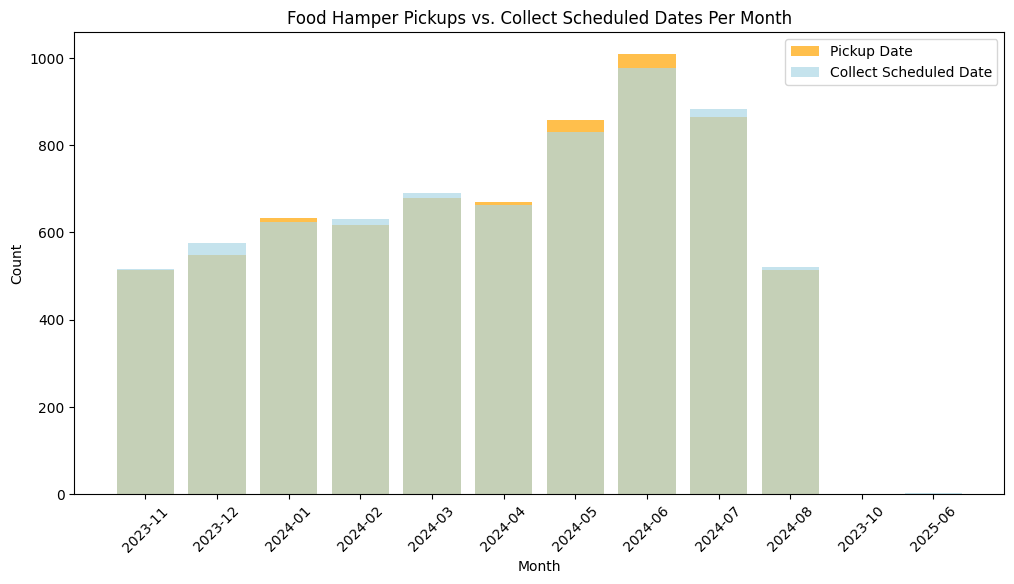

In [11]:
# Group by month for both pickup_date and collect_scheduled_date
pickup_counts = df.groupby(df["pickup_date"].dt.to_period("M")).size()
collect_counts = df.groupby(df["collect_scheduled_date"].dt.to_period("M")).size()

# Convert PeriodIndex to string for plotting
pickup_counts.index = pickup_counts.index.astype(str)
collect_counts.index = collect_counts.index.astype(str)

# Plot both on the same figure
plt.figure(figsize=(12, 6))
plt.bar(pickup_counts.index, pickup_counts, color="orange", alpha=0.7, label="Pickup Date")
plt.bar(collect_counts.index, collect_counts, color="lightblue", alpha=0.7, label="Collect Scheduled Date")

# Labels and title
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Food Hamper Pickups vs. Collect Scheduled Dates Per Month")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend()  # Add legend

plt.show()


In [12]:

# drop collect_scheduled_date before 2023-11
df = df[df['collect_scheduled_date'] >= '2023-11-01']

# drop collect_scheduled_date after 2024-08
df = df[df['collect_scheduled_date'] <= '2024-08-31']

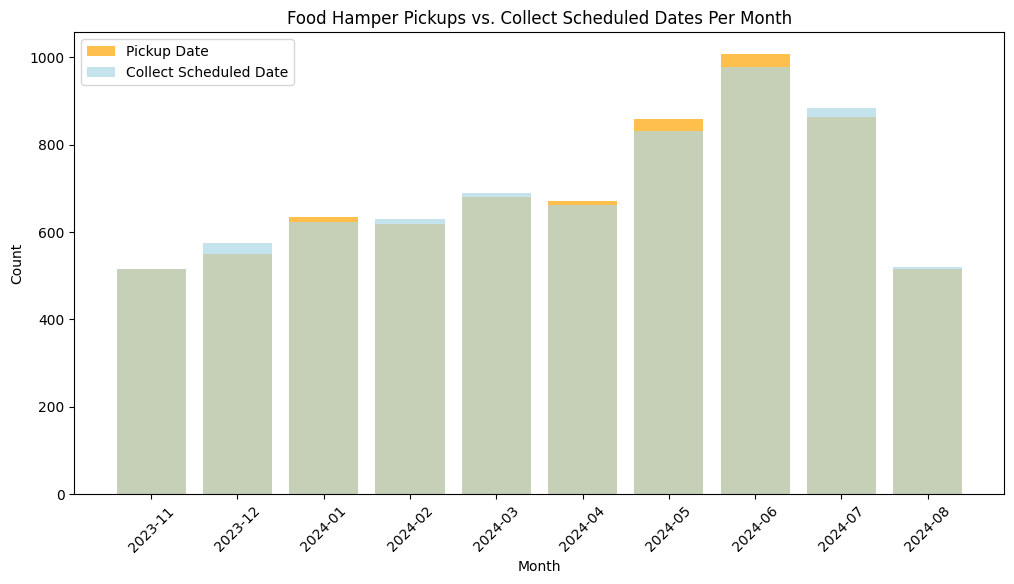

In [13]:
# Group by month for both pickup_date and collect_scheduled_date
pickup_counts = df.groupby(df["pickup_date"].dt.to_period("M")).size()
collect_counts = df.groupby(df["collect_scheduled_date"].dt.to_period("M")).size()

# Convert PeriodIndex to string for plotting
pickup_counts.index = pickup_counts.index.astype(str)
collect_counts.index = collect_counts.index.astype(str)

# Plot both on the same figure
plt.figure(figsize=(12, 6))
plt.bar(pickup_counts.index, pickup_counts, color="orange", alpha=0.7, label="Pickup Date")
plt.bar(collect_counts.index, collect_counts, color="lightblue", alpha=0.7, label="Collect Scheduled Date")

# Labels and title
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Food Hamper Pickups vs. Collect Scheduled Dates Per Month")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend()  # Add legend

plt.show()

# **Block 2: Model Selection & Training**





This section covers the process of selecting and training the model. 7 models were selected based on research about the best models for classification problems.


1.  **Cat Boosting**: This model handles categorical features and automatically manages overfitting through regularization parameters.
2.  **K-Nearest Neighbors**: This was selected for simplicity and effectiveness in capturing local patterns in the data, especially when the decision boundary is non-linear.
3.   **Decision Tree**:  is useful for its interpretability and ability to capture non-linear relationships by splitting data based on feature thresholds.
4. **LightGBM**: This model is highlly efficient with large datasets like ours. It also has fast traing speed.
5.  ** Random Forest Classifier**: Has the ability to handle high-dimensional data, reduce overfitting through ensemble learning, and provide feature importance insights.
6.   **Gradient Boosting**: Has a sequential technique that builds trees to correct errors from previous trees, often achieving high accuracy by focusing on difficult-to-classify instances.
7.   **XGBoost**: This has speed, scalability, and efficiency in handling large datasets with its gradient boosting framework and regularization techniques to prevent overfitting.



**Data splitting** - split the data using the train-tes split. The train-test split was performed based on the unique client IDs rather than random records. This ensures that the same clients do not appear in both the training and testing sets, preventing data leakage and providing a more realistic evaluation of model performance on unseen data.

**Feature Encoding** - One-hot encoding with most frequent imputation transforms categorical variables into binary features while handling missing values with the most common category. It ensures that the model interprets categorical data correctly without assuming any ordinal relationship.

**Normalization** - data was normalized using the StandardScaler as it is good for models which are sensitive to scales. It ensures that features with larger magnitudes do not dominate the model training process. The tree models - decision tree, Gradient Boosting and XGBoost work well with any scaling method.

**Stratified K-fold Cross Validation**- Used stratified 5-fold cross-validation to ensure reliable performance estimates

**Best performing Model** - The best performing model is XGBoost with an average f1-score of 0.9269

In [14]:
# Making a copy of the cleaned dataframe
df_copy = df.copy()

Map the target column or return category as  1 and O

In [15]:
df_copy['return_binary'] = df_copy['return_binary'].map({'Yes': 1, 'No': 0})

In [16]:
import pandas as pd

pd.set_option('display.max_rows', None)  # Display all rows
df_copy.head()

,agent_related,collect_scheduled_date,collect_token,hamper_type,pickup_date,related_scheduler,unique_client,Creation Date,Modified Date,Creator,...,dw,age_group,days_since_last_pickup,month,total_visits,avg_days_between_pickups,is_single_pickup,return_binary,distance_to_center,location_cluster
0,1668808073027x270650348760266270,2024-04-18 03:00:00,FP4WI9,1689345897790x875227980928652300,2024-04-19 00:22:00,1713496895503x822709837442842600,1669658091582x874637848970788900,2024-04-19 00:21:00,2024-04-19 00:22:00,1668808073027x270650348760266270,...,yes,"[35, 40)",0,4,2,13.0,False,1,5.036258,2
1,1668808073027x270650348760266270,2024-05-18 03:00:00,1KX81F,1689345897790x875227980928652300,2024-05-02 17:27:00,1713496895503x822709837442842600,1669658091582x874637848970788900,2024-04-19 00:21:00,2024-05-02 17:27:00,1668808073027x270650348760266270,...,yes,"[35, 40)",13,5,2,13.0,False,0,5.036258,2
2,1668808073027x270650348760266270,2024-04-18 03:00:00,QDWTTZ,1689345897790x875227980928652300,2024-05-01 15:48:00,1706204405955x558853613939589100,1673043106565x702758294392930300,2024-01-25 14:40:00,2024-05-01 15:48:00,1668808073027x270650348760266270,...,yes,"[35, 40)",0,5,6,19.6,False,1,3.324801,2
3,1668808073027x270650348760266270,2024-05-18 03:00:00,85L7QJ,1689345897790x875227980928652300,2024-05-31 11:36:00,1706204405955x558853613939589100,1673043106565x702758294392930300,2024-01-25 14:40:00,2024-05-31 11:36:00,1668808073027x270650348760266270,...,yes,"[35, 40)",29,5,6,19.6,False,1,3.324801,2
4,1668808073027x270650348760266270,2024-05-18 03:00:00,85L7QJ,1689345897790x875227980928652300,2024-05-31 11:36:00,1706204405955x558853613939589100,1673043106565x702758294392930300,2024-07-30 21:33:00,2024-08-02 11:34:00,(App admin),...,yes,"[35, 40)",0,5,6,19.6,False,1,3.324801,2


In [ ]:
df_copy.info()

In [17]:
df_copy = df_copy.drop(columns=['year_month'])

## Data split, Encoding, Model Training and Evaluation

Let's try splitting on unique id instead of new_client_id which we have dropped

In [ ]:
df_copy.info()

In [18]:
# Define Features
categorical_features = [
    'agent_related', 'hamper_type', 'related_scheduler', 'unique_client', 'Creator', 'unique id',
    'family', 'household', 'preferred_contact_methods',
    'preferred_languages', 'sex', 'status', 'age_group', 'dw']


numerical_features = [
    'dependents_qty', 'days_since_last_pickup',
    'month', 'total_visits', 'avg_days_between_pickups',
    'distance_to_center', 'location_cluster'
]

binary_features = ['is_single_pickup']  # Keep as-is

random_state = 42

# Ensure same clients do not appear in both train & test
unique_clients = df_copy["unique id"].unique().tolist()  # Convert to list explicitly

# Split unique clients into train and test sets
train_clients, test_clients = train_test_split(
    unique_clients, test_size=0.2, random_state=random_state
)

#train_clients = unique_clients[:int(0.8 * len(unique_clients))]
#test_clients = unique_clients[int(0.8 * len(unique_clients)):]  # Ensure the slice is a list

train_df = df_copy[df_copy["unique id"].isin(train_clients)]
test_df = df_copy[df_copy["unique id"].isin(test_clients)]


train_df = df_copy[df_copy["unique id"].isin(train_clients)]
test_df = df_copy[df_copy["unique id"].isin(test_clients)]

# Define features and target
X_train = train_df[categorical_features + numerical_features + binary_features]
y_train = train_df["return_binary"]
X_test = test_df[categorical_features + numerical_features + binary_features]
y_test = test_df["return_binary"]

# Define Transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])



models = {
    "Cat Boosting": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', CatBoostClassifier(
            iterations=500, learning_rate=0.05, depth=6, l2_leaf_reg=3, verbose=0, random_state=42
        ))
    ]),

    "K-Nearest Neighbors": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(
            n_neighbors=7, weights='distance', metric='minkowski'
        ))
    ]),

    "Decision Tree": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(
            max_depth=10, min_samples_split=10, random_state=42
        ))
    ]),

    "LightGBM": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(
            n_estimators=500, learning_rate=0.03, max_depth=7, num_leaves=20, min_data_in_leaf=20, subsample=0.8, scale_pos_weight=0.26, random_state=42
        ))
    ]),

    "Random Forest": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=200, max_depth=10, min_samples_split=5, random_state=42
        ))
    ]),

    "Gradient Boosting": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(
            n_estimators=200, learning_rate=0.05, max_depth=5, subsample=0.8, random_state=42
        ))
    ]),

    "XGBoost": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(
            n_estimators=200, learning_rate=0.05, max_depth=6, subsample=0.8, eval_metric='logloss', random_state=42
        ))
    ])
}

# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train and Evaluate Each Model
best_model = None
best_score = 0
best_params = {}
results = {}

# Train and evaluate models
for name, model in models.items():
    print(f"\nTraining {name}...")

    scores = [] # Initialize an empty list to store scores
    roc_auc_scores = [] # Initialize an empty list to store ROC AUC scores

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Apply preprocessing
        # Fit the training fold and transformed on the validation fold
        model.fit(X_train_fold, y_train_fold)

        # Evaluate
        y_pred = model.predict(X_val_fold)
        precision = precision_score(y_val_fold, y_pred)
        recall = recall_score(y_val_fold, y_pred)
        f1 = f1_score(y_val_fold, y_pred)
        roc_auc = roc_auc_score(y_val_fold, y_pred)

        # Append scores for each fold
        scores.append(f1)
        roc_auc_scores.append(roc_auc)  # Append ROC AUC score

        # store results for current fold to dictionary
        results[name] = {'precision': precision, 'recall': recall, 'f1_score': f1, 'roc_auc': roc_auc}

        print(f"{name} Metrics:")
        print(f" - Precision: {precision:.2f}")
        print(f" - Recall: {recall:.2f}")
        print(f" - F1-Score: {f1:.2f}")
        print(f" - ROC AUC: {roc_auc:.2f}\n")

    avg_f1 = np.mean(scores)
    avg_precision = np.mean([result['precision'] for result in results.values()])
    avg_recall = np.mean([result['recall'] for result in results.values()])
    avg_roc_auc = np.mean(roc_auc_scores)

    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average F1-score: {avg_f1:.4f}")
    print(f"Average ROC AUC: {avg_roc_auc:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")


    # Track best model
    if avg_f1 > best_score:
        best_score = avg_f1
        best_model = model
        best_params = model.get_params()

# Evaluate best model on test set

y_test_pred = best_model.predict(X_test)

#print("\nBest Model Performance on Test Set:")
print("="*40)
print(f"Best Model: {best_model.__class__.__name__}")
print(f"Best F1-Score: {best_score:.2f}")
print("="*40)
print(classification_report(y_test, y_test_pred))



# Save best model
joblib.dump(best_model, "best_model.pkl")
print(f"\nBest model '{best_model.named_steps['classifier'].__class__.__name__}' saved with F1-score: {best_score:.4f}")



Training Cat Boosting...
Cat Boosting Metrics:
 - Precision: 0.87
 - Recall: 0.98
 - F1-Score: 0.92
 - ROC AUC: 0.73

Cat Boosting Metrics:
 - Precision: 0.88
 - Recall: 0.99
 - F1-Score: 0.93
 - ROC AUC: 0.74

Cat Boosting Metrics:
 - Precision: 0.89
 - Recall: 0.98
 - F1-Score: 0.93
 - ROC AUC: 0.77

Cat Boosting Metrics:
 - Precision: 0.87
 - Recall: 0.97
 - F1-Score: 0.92
 - ROC AUC: 0.73

Cat Boosting Metrics:
 - Precision: 0.87
 - Recall: 0.99
 - F1-Score: 0.92
 - ROC AUC: 0.72

Average Precision: 0.8697
Average F1-score: 0.9255
Average ROC AUC: 0.7381
Average Recall: 0.9850

Training K-Nearest Neighbors...
K-Nearest Neighbors Metrics:
 - Precision: 0.81
 - Recall: 0.95
 - F1-Score: 0.87
 - ROC AUC: 0.55

K-Nearest Neighbors Metrics:
 - Precision: 0.80
 - Recall: 0.96
 - F1-Score: 0.87
 - ROC AUC: 0.55

K-Nearest Neighbors Metrics:
 - Precision: 0.81
 - Recall: 0.95
 - F1-Score: 0.87
 - ROC AUC: 0.56

K-Nearest Neighbors Metrics:
 - Precision: 0.81
 - Recall: 0.94
 - F1-Score: 0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 3468, number of negative: 951
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 4419, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.784793 -> initscore=1.293819
[LightGBM] [Info] Start training from score 1.293819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
LightGBM Metrics:
 - Precision: 0.91
 - Recall: 0.88
 - F1-Score: 0.89
 - ROC AUC: 0.79

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 3469, number of negative: 950
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 4419, number of used features: 82
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.785019 -> initscore=1.295160
[LightGBM] [Info] Start training from score 1.2

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 3469, number of negative: 950
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 4419, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.785019 -> initscore=1.295160
[LightGBM] [Info] Start training from score 1.295160
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



LightGBM Metrics:
 - Precision: 0.92
 - Recall: 0.84
 - F1-Score: 0.88
 - ROC AUC: 0.79

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 3469, number of negative: 950
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 4419, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.785019 -> initscore=1.295160
[LightGBM] [Info] Start training from score 1.295160
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
LightGBM Metrics:
 - Precision: 0.91
 - Recall: 0.86
 - F1-Score: 0.89
 - ROC AUC: 0.78

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 3469, number of negative: 951
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 4420, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.784842 -> initscore=1.294108
[LightGBM] [Info] Start training from score 1.2

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Random Forest Metrics:
 - Precision: 0.79
 - Recall: 1.00
 - F1-Score: 0.88
 - ROC AUC: 0.50

Random Forest Metrics:
 - Precision: 0.78
 - Recall: 1.00
 - F1-Score: 0.88
 - ROC AUC: 0.50

Random Forest Metrics:
 - Precision: 0.78
 - Recall: 1.00
 - F1-Score: 0.88
 - ROC AUC: 0.50

Random Forest Metrics:
 - Precision: 0.78
 - Recall: 1.00
 - F1-Score: 0.88
 - ROC AUC: 0.50

Random Forest Metrics:
 - Precision: 0.79
 - Recall: 1.00
 - F1-Score: 0.88
 - ROC AUC: 0.50

Average Precision: 0.8500
Average F1-score: 0.8795
Average ROC AUC: 0.5000
Average Recall: 0.9490

Training Gradient Boosting...
Gradient Boosting Metrics:
 - Precision: 0.88
 - Recall: 0.98
 - F1-Score: 0.92
 - ROC AUC: 0.74

Gradient Boosting Metrics:
 - Precision: 0.88
 - Recall: 0.98
 - F1-Score: 0.93
 - ROC AUC: 0.75

Gradient Boosting Metrics:
 - Precision: 0.89
 - Recall: 0.96
 - F1-Score: 0.93
 - ROC AUC: 0.77

Gradient Boosting Metrics:
 - Precision: 0.87
 - Recall: 0.97
 - F1-Score: 0.92
 - ROC AUC: 0.73

Gradient 

# Block 3: Model Evaluation & Diagnostics

Summary table and visuals created in this section to evaluate our key metrics and compare peformances across models.

## Summary Table of the model perfomance across folds

In [19]:
import pandas as pd

# Convert evaluation_metrics to a DataFrame
metrics_df = pd.DataFrame(results)

# Transpose the DataFrame and reset index
metrics_df = metrics_df.T.reset_index()

# Rename columns
metrics_df = metrics_df.rename(columns={'index': 'Model'})

# Group by model and compute mean metrics
summary_table = metrics_df.groupby('Model').mean().reset_index()

# Display the summary table
print("Summary Table of Model Performance:")
print(summary_table)

Summary Table of Model Performance:
                 Model  precision    recall  f1_score   roc_auc
0         Cat Boosting   0.869654  0.985006  0.923743  0.722461
1        Decision Tree   0.872340  0.945790  0.907582  0.719730
2    Gradient Boosting   0.872297  0.976932  0.921654  0.726863
3  K-Nearest Neighbors   0.806673  0.948097  0.871686  0.558437
4             LightGBM   0.915854  0.866205  0.890338  0.787533
5        Random Forest   0.785326  1.000000  0.879756  0.500000
6              XGBoost   0.881126  0.974625  0.925520  0.746806


## Best performing Model bases on f1-score



In [20]:
#print("\nBest Model Performance on Test Set:")
print("="*40)
print(f"Best Model: {best_model.named_steps['classifier'].__class__.__name__}")
print(f"Best F1-Score: {best_score:.2f}")
print("="*40)
print(classification_report(y_test, y_test_pred))
print(f"\nBest model '{best_model.named_steps['classifier'].__class__.__name__}' saved with F1-score: {best_score:.4f}")

Best Model: CatBoostClassifier
Best F1-Score: 0.93
              precision    recall  f1-score   support

           0       0.83      0.48      0.61       293
           1       0.88      0.97      0.92      1089

    accuracy                           0.87      1382
   macro avg       0.85      0.73      0.77      1382
weighted avg       0.86      0.87      0.86      1382


Best model 'CatBoostClassifier' saved with F1-score: 0.9255


## Bar plot showing the metrics for all models trained

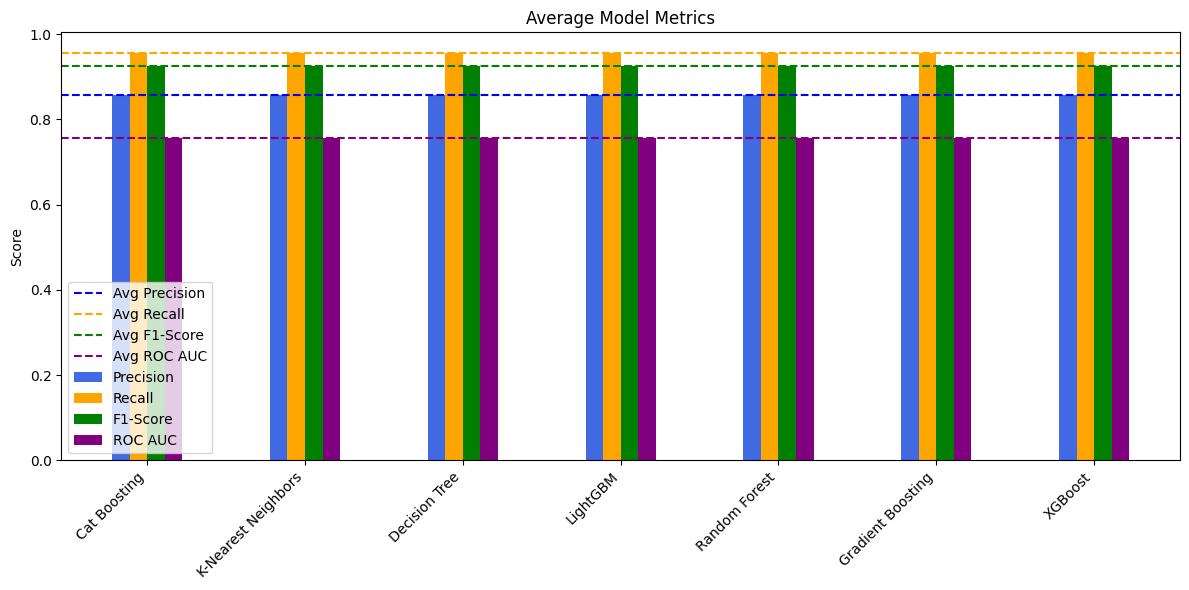

In [21]:
# Initialize lists to store evaluation metrics outside the loop
model_names = []  # List to store model names
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Train and evaluate models, appending metrics for each model
for name, model in models.items():


    # Append metrics to their respective lists for plotting
    precision_scores.append(avg_precision)
    recall_scores.append(avg_recall)
    f1_scores.append(avg_f1)
    roc_auc_scores.append(avg_roc_auc)
    model_names.append(name)  # Append model name to the list

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.2  # Width of each bar
spacing_factor = 1.8  # Controls the spacing between clusters
x_pos = np.arange(len(model_names)) * spacing_factor  # Ensure correct spacing

# Plot bars with spacing
ax.bar(x_pos, precision_scores, width=bar_width, label='Precision', color='royalblue')
ax.bar(x_pos + bar_width, recall_scores, width=bar_width, label='Recall', color='orange')
ax.bar(x_pos + 2 * bar_width, f1_scores, width=bar_width, label='F1-Score', color='green')
ax.bar(x_pos + 3 * bar_width, roc_auc_scores, width=bar_width, label='ROC AUC', color='purple')

# Add average lines
ax.axhline(y=avg_precision, color='blue', linestyle='--', label='Avg Precision')
ax.axhline(y=avg_recall, color='orange', linestyle='--', label='Avg Recall')
ax.axhline(y=avg_f1, color='green', linestyle='--', label='Avg F1-Score')
ax.axhline(y=avg_roc_auc, color='purple', linestyle='--', label='Avg ROC AUC')

# Set plot labels and title
ax.set_xticks(x_pos + 1.5 * bar_width)  # Adjust x-tick positions for readability
ax.set_xticklabels(model_names, rotation=45, ha='right')  # Rotate x-axis labels if needed
ax.set_ylabel('Score')
ax.set_title('Average Model Metrics')
ax.legend()

plt.tight_layout()
plt.show()


## Plot of confusion matrix results for all models

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


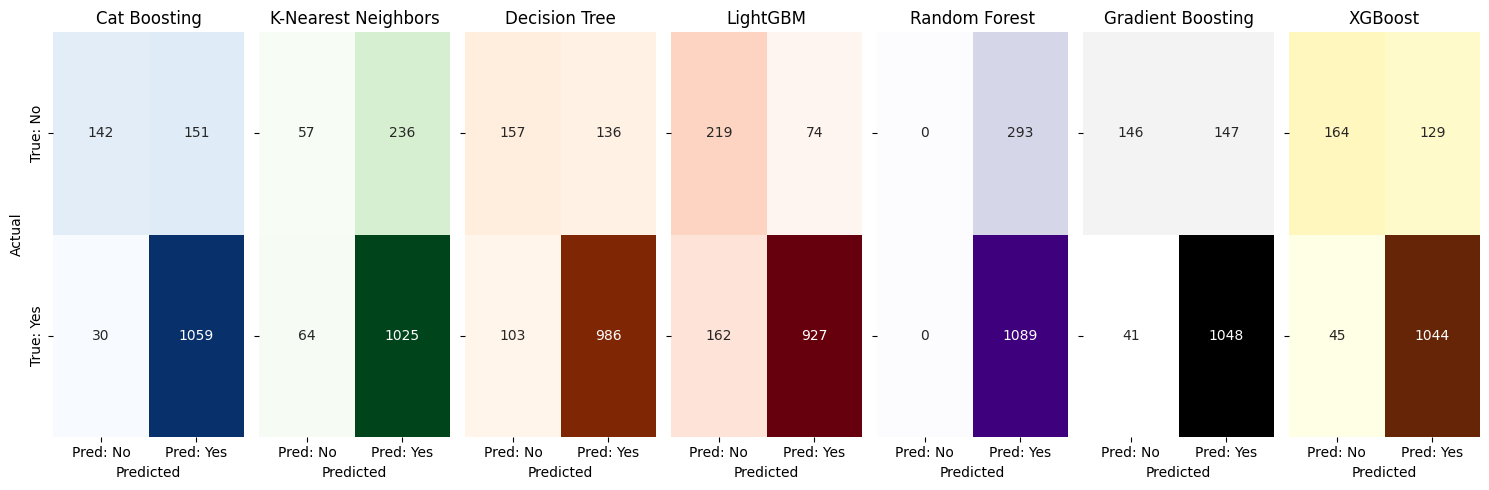

In [22]:
# Define a list of colormaps for each model's confusion matrix
colormaps = ['Blues', 'Greens', 'Oranges', 'Reds', 'Purples', 'Greys', 'YlOrBr' ]


fig, axes = plt.subplots(1, len(models), figsize=(15, 5), sharey=True)

for i, (model_name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Use the corresponding colormap for this model
    sns.heatmap(cm, annot=True, fmt='d', cmap=colormaps[i], ax=axes[i],
                cbar=False,
                xticklabels=['Pred: No', 'Pred: Yes'],
                yticklabels=['True: No', 'True: Yes'])

    axes[i].set_title(model_name)
    axes[i].set_xlabel('Predicted')

    if i == 0:
        axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## Precision-Recall Curves for all models

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


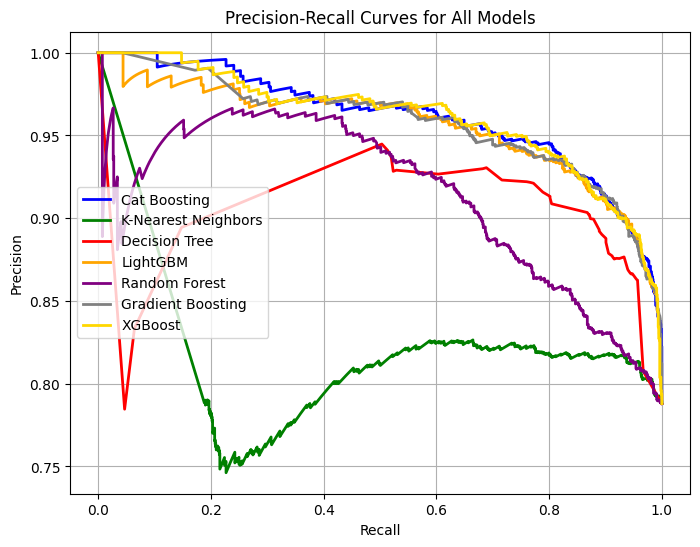

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Define colors for each model using standard color names or hexadecimal codes
colors = ['blue', 'green', 'red', 'orange', 'purple', 'grey', 'gold']  # Replace 'YlOrBr' with a valid color


plt.figure(figsize=(8, 6))

for i, (model_name, model) in enumerate(models.items()):
    y_probs = model.predict_proba(X_test)[:, 1]  # Probabilities of the positive class
    precision, recall, _ = precision_recall_curve(y_test, y_probs)

    # Plot the curve for the current model
    plt.plot(recall, precision, color=colors[i], lw=2, label=model_name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for All Models')
plt.legend(loc='best')  # Add legend to identify models
plt.grid(True)
plt.show()

## ROC curves for all models

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


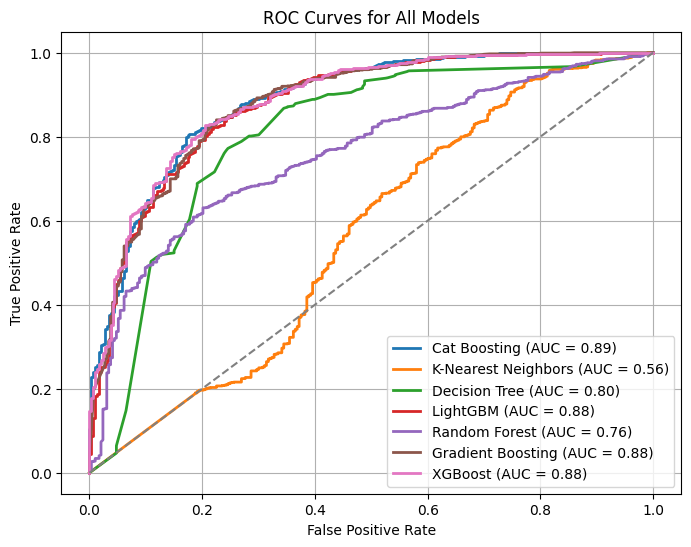

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


plt.figure(figsize=(8, 6))

for i, (model_name, model) in enumerate(models.items()):
    # Get probabilities for the positive class
    y_probs = model.predict_proba(X_test)[:, 1]

    # Get ROC curve data
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)

    # Plot ROC curve for the current model
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Block 4: Model Optimization & Hyperparameter Tuning

## Hyperparameter Tuning of our best performing model - XGBoost

Hypertuning was carried out on our best performing model - CatBoost using Random searchCV to efficiently explore the hyperparameter space by testing 20 random combinations.  




In [25]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
import numpy as np
import joblib

# Define hyperparameter distribution
param_dist = {
    #'classifier__iterations': [500, 1000, 1500],
    'classifier__iterations': [500],
    'classifier__learning_rate': np.linspace(0.01, 0.1, 5),
    'classifier__depth': [4, 6, 8, 10],
    'classifier__l2_leaf_reg': [1, 3, 5, 7]
}

# Retrieve the CatBoost pipeline
catboost_pipeline = models["Cat Boosting"]

# Initialize RandomizedSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    catboost_pipeline,
    param_dist,
    scoring='f1',  # Optimize for F1-score
    cv=cv,
    verbose=1,
    n_jobs=-1,
    n_iter=20,  # Number of different combinations to try
    random_state=42
)

# Fit RandomizedSearchCV

print("Performing hyperparameter tuning...")
random_search.fit(X_train, y_train)

# Get best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Evaluate best model on test set
y_test_pred = random_search.best_estimator_.predict(X_test)
print("\nBest Model Performance on Test Set:")
print(classification_report(y_test, y_test_pred))

# Save best model
joblib.dump(random_search.best_estimator_, "best_catboost_model.pkl")
print(f"\nBest CatBoost model saved with F1-score: {random_search.best_score_:.4f}")

Performing hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'classifier__learning_rate': 0.01, 'classifier__l2_leaf_reg': 7, 'classifier__iterations': 500, 'classifier__depth': 8}

Best Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.82      0.49      0.61       293
           1       0.88      0.97      0.92      1089

    accuracy                           0.87      1382
   macro avg       0.85      0.73      0.77      1382
weighted avg       0.86      0.87      0.86      1382


Best CatBoost model saved with F1-score: 0.9270


## Feature Importance

Feature Importance on catboost model

In [26]:
# Load the trained model
best_catboost_model = joblib.load("best_catboost_model.pkl")  # Load the model

# Get feature names after preprocessing
# Fit the preprocessor on the training data
best_catboost_model.named_steps['preprocessor'].fit(X_train)

# Get feature names from the preprocessor
feature_names = best_catboost_model.named_steps['preprocessor'].get_feature_names_out()


# Access the CatBoostClassifier within the pipeline using named_steps
importances = best_catboost_model.named_steps['classifier'].feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Remove 'cat_' and 'num_' prefixes from feature names
feature_importances['feature'] = feature_importances['feature'].str.replace(r'^(cat__|num__)', '', regex=True)

# Save as CSV
feature_importances.to_csv('feature_importances.csv', index=False)

# Print or visualize the feature importances
feature_importances.head(20)

,feature,importance
2,month,59.197659
3,total_visits,15.887618
4,avg_days_between_pickups,11.484806
1,days_since_last_pickup,7.980081
5,distance_to_center,0.840428
0,dependents_qty,0.663583
6,location_cluster,0.441391
2695,Creator_(App admin),0.366227
9333,sex_Female,0.227846
16,agent_related_1695924383527x556410987519920600,0.226554


## Plot of the top 10 Features

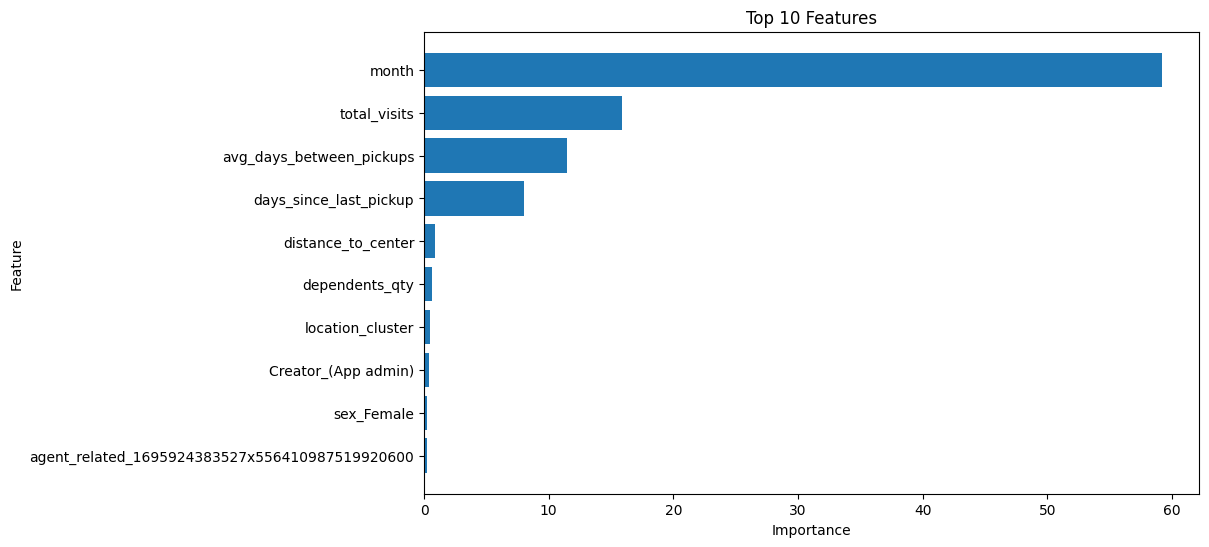

In [27]:
import matplotlib.pyplot as plt
# Select top 10 features
top_10_features = feature_importances.head(10)

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.barh(top_10_features['feature'], top_10_features['importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Features")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


Aggregate the features

## Retrain Model with Top 4 features

In [28]:
# Get the top 7 features
top_7_features = feature_importances.head(7)['feature'].tolist()

# Print the list of top 7 features
print(top_7_features)

['month', 'total_visits', 'avg_days_between_pickups', 'days_since_last_pickup', 'distance_to_center', 'dependents_qty', 'location_cluster']


In [29]:
# Get the top 5 features
top_7_features = feature_importances.head(7)['feature'].tolist()

# Create new training and testing sets with only the top 5 features
# Using the original column names without prefixes
X_train_top7 = X_train[[f for f in top_7_features if f in X_train.columns]]
X_test_top7 = X_test[[f for f in top_7_features if f in X_test.columns]]

# Scale the data
scaler_top7 = StandardScaler()
X_train_top7_scaled = scaler_top7.fit_transform(X_train_top7)
X_test_top7_scaled = scaler_top7.transform(X_test_top7)

# Retrain the model using only the top 5 features
# Create a new CatBoostClassifier with the desired parameters
model_top7 = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Apply scaling within the pipeline
    ('classifier', CatBoostClassifier(
        learning_rate=0.01,
        l2_leaf_reg=3,
        iterations=500,
        depth=8,
        random_state=42,  # Add random_state for reproducibility
        verbose=0  # Suppress verbose output
    ))
])
model_top7.fit(X_train_top7_scaled, y_train)


# Make predictions on the test set
y_pred_top7 = model_top7.predict(X_test_top7_scaled)

# Evaluate the model
print("Accuracy (Top 7 Features):", accuracy_score(y_test, y_pred_top7))
print("Classification Report (Top 7 Features):\n", classification_report(y_test, y_pred_top7))

Accuracy (Top 7 Features): 0.8661360347322721
Classification Report (Top 7 Features):
               precision    recall  f1-score   support

           0       0.78      0.52      0.62       293
           1       0.88      0.96      0.92      1089

    accuracy                           0.87      1382
   macro avg       0.83      0.74      0.77      1382
weighted avg       0.86      0.87      0.86      1382



In [30]:
# download model

import joblib

# Save the trained model and scaler to a file
joblib.dump(model_top7, 'model_top7.pkl')
joblib.dump(scaler_top7, 'scaler_top7.pkl')

['scaler_top7.pkl']

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.9 MB/s eta 0:00:00


In [ ]:
pip freeze > requirements.txt

In [ ]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://104.199.167.49:8501

  Stopping...
^C


# SCRIPT FOR STREAMLIT AND XAI GRAPHS

In [ ]:
import streamlit as st
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.inspection import PartialDependenceDisplay

# Check for SHAP library
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    st.warning("SHAP library not installed. Some explanation features will be limited.")

# Load the trained model with caching
@st.cache_resource
def load_model():
    try:
        model = joblib.load("model_top4.pkl")
        st.success("✅ Model loaded successfully!")

        # Debug: Show model structure
        if st.session_state.get('debug', False):
            st.write("Model type:", type(model))
            if hasattr(model, 'named_steps'):
                st.write("Pipeline steps:", list(model.named_steps.keys()))
            if hasattr(model, 'feature_importances_'):
                st.write("Model has feature_importances_ attribute")

        return model
    except Exception as e:
        st.error(f"❌ Error loading model: {e}")
        return None

model = load_model()

# Define only the top 5 features
REQUIRED_COLUMNS = [

    "month",
    "total_visits",
    "avg_days_between_pickups",
    "days_since_last_pickup"
]

# Function to preprocess input data
def preprocess_input(input_data):
    input_df = pd.DataFrame([input_data])

    # Ensure all required columns exist
    for col in REQUIRED_COLUMNS:
        if col not in input_df.columns:
            input_df[col] = 0  # Set missing columns to 0

    # Ensure the column order matches model training
    input_df = input_df[REQUIRED_COLUMNS]
    return input_df

def exploratory_data_analysis():
    st.subheader("Hamper Collection Insights")
    st.title("Power BI Visualization")
    powerbi_url = "https://app.powerbi.com/view?r=eyJrIjoiMTE4Y2JiYWQtMzNhYS00NGFiLThmMDQtMmIwMDg4YTIzMjI5IiwidCI6ImUyMjhjM2RmLTIzM2YtNDljMy05ZDc1LTFjZTI4NWI1OWM3OCJ9"
    st.components.v1.iframe(powerbi_url, width=800, height=600)

def get_model_components():
    """Extract model components handling different pipeline structures"""
    components = {
        'preprocessor': None,
        'classifier': None,
        'feature_names': REQUIRED_COLUMNS
    }

    if hasattr(model, 'named_steps'):
        # Handle pipeline models
        possible_preprocessor_names = ['preprocessor', 'pre', 'transform', 'features']
        possible_classifier_names = ['classifier', 'model', 'clf', 'estimator']

        for name in possible_preprocessor_names:
            if name in model.named_steps:
                components['preprocessor'] = model.named_steps[name]
                break

        for name in possible_classifier_names:
            if name in model.named_steps:
                components['classifier'] = model.named_steps[name]
                break
    else:
        # Handle non-pipeline models
        components['classifier'] = model

    # Get feature names if preprocessor exists
    if components['preprocessor'] is not None and hasattr(components['preprocessor'], 'get_feature_names_out'):
        components['feature_names'] = [name.split('__')[-1] for name in components['preprocessor'].get_feature_names_out()]

    return components

def show_shap_analysis(input_df, prediction, probability):
    if not SHAP_AVAILABLE:
        st.warning("""
        **SHAP explanations unavailable**
        To enable full explanation features, please install SHAP:
        `pip install shap` or restart the app in an environment with SHAP installed.
        """)
        return

    st.subheader("🔍 Prediction Explanation")

    try:
        components = get_model_components()
        classifier = components['classifier']

        if classifier is None:
            st.error("Could not identify classifier in model pipeline")
            return

        # Process input data
        if components['preprocessor'] is not None:
            X_processed = components['preprocessor'].transform(input_df)
        else:
            X_processed = input_df.values

        feature_names = components['feature_names']

        # Convert to dense if sparse
        if hasattr(X_processed, 'toarray'):
            X_processed = X_processed.toarray()

        # Create SHAP explainer
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_processed)

        # For binary classification
        if isinstance(shap_values, list) and len(shap_values) == 2:
            shap_values = shap_values[1]

        # Create tabs for different visualizations
        tab1, tab2 = st.tabs(["Feature Importance", "Prediction Breakdown"])

        with tab1:
            st.write("**Global Feature Importance**")
            fig, ax = plt.subplots(figsize=(10, 6))
            shap.summary_plot(shap_values, X_processed, feature_names=feature_names, plot_type="bar", show=False)
            plt.tight_layout()
            st.pyplot(fig)
            st.caption("This shows which features most influence model predictions overall.")

        with tab2:
            st.write("**How Each Feature Contributed to This Prediction**")

            # Create waterfall plot
            base_value = explainer.expected_value
            contribution = shap_values[0]

            # Create dataframe for plot
            df_waterfall = pd.DataFrame({
                'Feature': ['Base Value'] + feature_names,
                'SHAP Value': [base_value] + list(contribution)
            })

            # Color based on positive/negative contribution
            df_waterfall['Color'] = df_waterfall['SHAP Value'].apply(
                lambda x: 'Positive' if x > 0 else 'Negative')

            fig = px.bar(df_waterfall,
                        x='SHAP Value',
                        y='Feature',
                        color='Color',
                        color_discrete_map={'Positive': '#FF0051', 'Negative': '#008BFB'},
                        orientation='h',
                        title=f"Feature Contributions to Prediction")

            # Add base value line
            fig.add_vline(x=base_value, line_dash="dash", line_color="gray")
            fig.update_layout(showlegend=False)

            st.plotly_chart(fig, use_container_width=True)

            # Show feature values
            st.write("**Feature Values for This Prediction:**")
            feature_values = {f: v for f, v in zip(feature_names, X_processed[0])}
            st.json(feature_values)

    except Exception as e:
        st.error(f"Error generating explanations: {str(e)}")
        st.warning("Model structure may not be compatible with automatic explanation generation")

def show_confidence_analysis(probability):
    st.subheader("📊 Prediction Confidence")

    # Create confidence gauge
    fig = go.Figure(go.Indicator(
        mode = "gauge+number",
        value = probability[0][1],
        domain = {'x': [0, 1], 'y': [0, 1]},
        title = {'text': "Confidence Level"},
        gauge = {
            'axis': {'range': [0, 1]},
            'steps': [
                {'range': [0, 0.3], 'color': "lightgray"},
                {'range': [0.3, 0.7], 'color': "gray"},
                {'range': [0.7, 1], 'color': "darkgray"}],
            'threshold': {
                'line': {'color': "red", 'width': 4},
                'thickness': 0.75,
                'value': probability[0][1]}}
    ))

    st.plotly_chart(fig, use_container_width=True)

    # Interpretation
    if probability[0][1] < 0.3 or probability[0][1] > 0.7:
        st.success("✅ High confidence prediction")
        st.write("The model is very confident in this prediction due to clear patterns in the input data.")
    else:
        st.warning("⚠️ Medium confidence prediction")
        st.write("The model has moderate confidence. Consider verifying with additional client information.")

def predictions_page():
    st.title("Hamper Return Prediction App")
    st.write("Enter details to predict if a client will return.")

    # User input fields
    col1, col2 = st.columns(2)
    with col1:
        month = st.number_input("Month", min_value=1, max_value=12, step=1, value=6)
        total_visits = st.number_input("Total Visits", min_value=1, max_value=100, step=1, value=5)

    with col2:
        avg_days_between_pickups = st.number_input("Avg Days Between Pickups",
                                                min_value=1.0, max_value=100.0,
                                                step=0.1, value=30.0)
        days_since_last_pickup = st.number_input("Days Since Last Pickup",
                                                min_value=1.0, max_value=100.0,
                                                step=0.1, value=30.0)

    input_data = {
        "month": month,
        "total_visits": total_visits,
        "avg_days_between_pickups": avg_days_between_pickups,
        "days_since_last_pickup": days_since_last_pickup

    }

    # Prediction button
    if st.button("Predict"):
        if model is None:
            st.error("Model not loaded. Please check if 'model_top4.pkl' exists.")
        else:
            input_df = preprocess_input(input_data)
            prediction = model.predict(input_df)
            probability = model.predict_proba(input_df)

            # Show prediction result
            st.subheader("🎯 Prediction Result")

            if prediction[0] == 1:
                st.success(f"✅ The client is **likely to RETURN** (probability: {probability[0][1]:.2%})")
            else:
                st.error(f"❌ The client is **NOT likely to RETURN** (probability: {probability[0][0]:.2%})")

            # Show SHAP analysis
            show_shap_analysis(input_df, prediction, probability)

            # Show confidence analysis
            show_confidence_analysis(probability)

            # Recommendation based on prediction
            st.subheader("💡 Recommended Actions")
            if prediction[0] == 1:
                st.markdown("""
                - **Follow up:** Schedule a reminder for their next expected pickup
                - **Retention:** Consider adding them to loyalty communications
                - **Feedback:** Ask about their experience to maintain engagement
                """)
            else:
                st.markdown("""
                - **Outreach:** Consider a check-in call to understand their situation
                - **Incentives:** Offer additional support if appropriate
                - **Feedback:** Learn why they might not be returning
                """)

def dashboard():
    header_image_url = "https://raw.githubusercontent.com/ChiomaUU/Client-Prediction/refs/heads/main/ifssa_2844cc71-4dca-48ae-93c6-43295187e7ca.avif"
    st.image(header_image_url, use_container_width=True)

    st.title("Hamper Return Prediction App")
    st.write("This app predicts whether a client will return for food hampers using machine learning.")

    st.markdown("""
    ### Key Features:
    - **Predictions:** Estimate return probability for individual clients
    - **Explainability:** Understand why the model makes each prediction
    - **Confidence Metrics:** See how certain the model is about each prediction
    """)

    st.markdown("""
    ### How It Works:
    1. Navigate to the **Predictions** page
    2. Enter client details
    3. Get the prediction with explanations
    4. View recommended actions
    """)

def main():
    st.sidebar.title("Navigation")
    app_page = st.sidebar.radio("Choose a page", ["Dashboard", "Insights", "Predictions"])

    # Debug toggle
    if st.sidebar.checkbox("Debug mode"):
        st.session_state.debug = True
    else:
        st.session_state.debug = False

    if app_page == "Dashboard":
        dashboard()
    elif app_page == "Insights":
        exploratory_data_analysis()
    elif app_page == "Predictions":
        predictions_page()

    # Add footer
    st.sidebar.markdown("---")
    st.sidebar.markdown("""
    **About This App:**
    - Uses machine learning model
    - Provides explainable AI insights
    - Designed for food bank client retention
    """)

if __name__ == "__main__":
    main()

## **RETRIEVAL-AUGMENTED GENERATION (RAG)**

In [ ]:
# Access the API key from Streamlit secrets
api_key = st.secrets["api_keys"]["GOOGLE_API_KEY"]

# Configure the API key
genai.configure(api_key=api_key)

# Loading dataset
df1 = pd.read_csv("df.csv")  # Update with your actual dataset file

# Function to extract text from a preloaded PDF
def extract_text_from_pdf(pdf_path):
    text = ""
    try:
        with open(pdf_path, "rb") as pdf_file:
            reader = PyPDF2.PdfReader(pdf_file)
            for page in reader.pages:
                text += page.extract_text() + "\n"
    except Exception as e:
        st.error(f"Error reading PDF: {e}")
    return text

# Preload the PDF
pdf_path = "IFSSA and Insights.pdf"  # Update with your actual PDF file
pdf_text = extract_text_from_pdf(pdf_path)

# Function to generate response from the model
def generate_response(prompt, context):
    try:
        model = genai.GenerativeModel('models/gemini-1.5-pro-latest')

        # Remove explicit source references from context if necessary
        cleaned_context = context.replace("PDF Content:", "").replace("Dataset 1 Preview:", "")

        # Generate content based on the cleaned context
        response = model.generate_content(f"{prompt}\n\nContext:\n{cleaned_context}")
        return response.text
    except Exception as e:
        st.error(f"Error generating response: {e}")
        return "Sorry, I couldn't process your request."

def chatbox():
    # Function to extract text from a preloaded PDF

    def extract_text_from_pdf(pdf_path):
        text = ""
        try:
            with open(pdf_path, "rb") as pdf_file:
                reader = PyPDF2.PdfReader(pdf_file)
                for page in reader.pages:
                    text += page.extract_text() + "\n"
        except Exception as e:
            st.error(f"Error reading PDF: {e}")
        return text

    # Preload the PDF
    pdf_path = "IFSSA and Insights.pdf"  # Update with your actual PDF file
    pdf_text = extract_text_from_pdf(pdf_path)
    if not pdf_text:
        pdf_text = ""  # Ensure pdf_text is an empty string if extraction fails

    # Function to generate response from the model
    def generate_response(prompt, context):
        try:
            model = genai.GenerativeModel('models/gemini-1.5-pro-latest')
            # Remove explicit source references from context if necessary
            cleaned_context = context.replace("PDF Content:", "").replace("Dataset 1 Preview:", "")
            # Generate content based on the cleaned context
            response = model.generate_content(f"{prompt}\n\nContext:\n{cleaned_context}")
            return response.text
        except Exception as e:
            st.error(f"Error generating response: {e}")
            return "Sorry, I couldn't process your request."


    st.markdown('<h1 style="color:#E09963; font-size: 2.5em;">IFSSA Retention Chatbot</h1>', unsafe_allow_html=True)
    st.write("Ask questions based on your datasets.")
    st.write("Some types of questions you can ask include: 'What are the preferred languages?', 'What are the age groups of clients?', 'What are the preferred contact methods?'")

    # Create context from dataset
    context = "\nDataset 1 Preview:\n" + df1.head(5).to_string()
    context += "\n\nPDF Content:\n" + pdf_text[:2000]  # Limit text for efficiency

    # Initialize chat history if not already initialized
    if "chat_history" not in st.session_state:
        st.session_state.chat_history = []

    # User input
    user_input = st.text_input("Ask a question about our data:", key="input")

    # If user presses "Send", process the question
    if st.button("Send"):
        if user_input:
            # Store user message at the top of the chat history
            st.session_state.chat_history.insert(0, {"role": "user", "content": user_input})
            # Generate response from the model
            response = generate_response(user_input, context)
            # Store assistant response below the user message
            st.session_state.chat_history.insert(1, {"role": "assistant", "content": response})

    # Display chat history, with most recent messages on top
    for message in st.session_state.chat_history:
        st.write(f"**{message['role'].capitalize()}**: {message['content']}")

